In [1]:
import h5py
import torch
import torch.nn as nn
from torch.legacy.nn import Reshape
from torch.autograd import Variable
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
import torch.utils.data as utils
import numpy as np
import matplotlib.pyplot as plt
from scipy.misc import imresize, imread, imshow
import time
from math import log,sqrt
import torch.nn.functional as F

In [2]:
torch.cuda.current_device()

0

In [3]:
def InitializeWeights(mod):
    for m in mod.modules():
        if isinstance(m,nn.Conv2d):
            n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            #print m.weight.size(), m.out_channels, m.in_channels
            m.weight.data.normal_(0,sqrt(2./n))
        elif isinstance(m, nn.BatchNorm2d):
            m.weight.data.fill_(1)
            m.bias.data.zero_()
    return mod

In [4]:
class Corridor(nn.Module):

    def __init__(self):
        super(Corridor, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = InitializeWeights(nn.Conv2d(3, 6, 7, 2))
        self.conv2 = InitializeWeights(nn.Conv2d(6, 16, 5, 2))
        self.conv3 = InitializeWeights(nn.Conv2d(16, 20, 3, 1))
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(20 * 4 * 8, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.fc4 = nn.Linear(10, 1)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = F.max_pool2d(F.relu(self.conv3(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


net = Corridor()
print(net)

Corridor (
  (conv1): Conv2d(3, 6, kernel_size=(7, 7), stride=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(2, 2))
  (conv3): Conv2d(16, 20, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear (640 -> 120)
  (fc2): Linear (120 -> 84)
  (fc3): Linear (84 -> 10)
  (fc4): Linear (10 -> 1)
)


In [5]:
params = list(net.parameters())
print(len(params))
print(params[0].size())  # conv1's .weight

14
torch.Size([6, 3, 7, 7])


In [6]:
sum1 = 0
        
print("Number of layers ---> ",len(list(net.parameters())))
for params in net.parameters():
    if params.requires_grad == True:
        sum1 += params.numel()
    
print("Total number of parameters ---> ",sum1)

Number of layers --->  14
Total number of parameters --->  94149


In [7]:
input = Variable(torch.randn(5, 3, 180, 320))
out = net(input)
print(out)

Variable containing:
 0.1421
 0.1653
 0.1395
 0.1500
 0.1433
[torch.FloatTensor of size 5x1]



In [ ]:
net = net.cuda()

In [8]:
file = h5py.File('./DATASET/CODE/NewTrainData.h5')
xtrainT = torch.from_numpy(np.array(file['xtrain'],dtype=np.float32)).float()
ytrainT = torch.from_numpy(np.array(file['ytrain'],dtype=np.float32)).float()
#xtrain = np.array(file['xtrain'],dtype=np.float32)
#ytrain = np.array(file['ytrain'],dtype=np.float32)

In [13]:
print(xtrainT.size(), ytrainT.size())

torch.Size([11884, 3, 180, 320]) torch.Size([11884, 2])


In [9]:
file = h5py.File('./DATASET/CODE/NewTestData.h5')
xtestT = torch.from_numpy(np.array(file['xtest'],dtype=np.float32)).float()
ytestT = torch.from_numpy(np.array(file['ytest'],dtype=np.float32)).float()
#xtest = np.array(file['xtest'],dtype=np.float32)
#ytest = np.array(file['ytest'],dtype=np.float32)

In [14]:
print(xtestT.size(), ytestT.size())

torch.Size([2516, 3, 180, 320]) torch.Size([2516, 2])


In [77]:
def batch_rgb_to_bgr(batch):
    #print(batch.size())
    (r, g, b) = torch.chunk(batch, 3, 1)
    #print(r.size())
    batch1 = torch.cat((b, g, r),1)
    #print(batch1.size())
    return batch1

In [78]:
xtrainT = batch_rgb_to_bgr(xtrainT)
print(xtrainT.size())

torch.Size([11884, 3, 180, 320])
torch.Size([11884, 1, 180, 320])
torch.Size([11884, 3, 180, 320])
torch.Size([11884, 3, 180, 320])


In [65]:
def batch_rgb_to_bgr(batch):
    print(batch.shape)
    batch = batch.transpose(1,0,2,3)
    #print batch.shape
    #batch1 = torch.from_numpy(batch).float()
    #(r, g, b) = torch.chunk(batch1, 3)
    r,g,b = np.split(batch,3,0)
    print(r.shape)
    #batch1 = torch.cat((b, g, r))
    batch = np.concatenate((b,g,r),0)
    print(batch.shape)
    #batch = batch1.numpy()
    batch = batch.transpose(1,0,2,3)
    print(batch.shape)
    return batch

In [ ]:
xtrain = batch_rgb_to_bgr(xtrain)
xtest = batch_rgb_to_bgr(xtest)

In [ ]:
print(np.max(xtrain),np.max(ytrain))
print(np.max(xtest),np.max(ytest))

In [14]:
xtrain /= 255.0
xtest /= 255.0

In [15]:
xtrainT = torch.from_numpy(xtrain).float()
ytrainT = torch.from_numpy(ytrain).float()
xtestT = torch.from_numpy(xtest).float()
ytestT = torch.from_numpy(ytest).float()

In [10]:
xtrainT = torch.div(xtrainT,255.0)
xtestT = torch.div(xtestT,255.0)

In [11]:
print(torch.min(xtrainT), torch.max(xtrainT), torch.min(xtestT), torch.max(xtestT))

0.0 1.0 0.0 1.0


In [12]:
print(xtrainT.size(), ytrainT.size(), xtestT.size(), ytestT.size())

torch.Size([11884, 3, 180, 320]) torch.Size([11884, 2]) torch.Size([2516, 3, 180, 320]) torch.Size([2516, 2])


In [13]:
class Normalize(object):
    """
    Normalize an tensor image with mean and standard deviation.
    Given mean: (R, G, B) and std: (R, G, B),
    will normalize each channel of the torch.*Tensor, i.e.
    channel = (channel - mean) / std
    Args:
        mean (sequence): Sequence of means for R, G, B channels respecitvely.
        std (sequence): Sequence of standard deviations for R, G, B channels
            respecitvely.
    """

    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        # TODO: make efficient
        for t, m, s in zip(tensor, self.mean, self.std):
            t.sub_(m).div_(s)
        return tensor

In [12]:
mn1 = [0,0,0]
sd1 = [255.0,255.0,255.0]
norm1 = Normalize(mn1,sd1)
xtrainT = norm1(xtrainT)
xtestT = norm1(xtestT)

In [14]:
print(torch.min(xtrainT), torch.max(xtrainT), torch.min(xtestT), torch.max(xtestT))

0.0 1.0 0.0 1.0


In [15]:
#mn = [0.406,0.456,0.485]
#sd = [0.225,0.224,0.229]
mn = [0.485,0.456,0.406]
sd = [0.229,0.224,0.225]
norm = Normalize(mn,sd)
xtrainT1 = norm(xtrainT)
xtestT1 = norm(xtestT)

In [16]:
print(torch.min(xtrainT1), torch.max(xtrainT1), torch.min(xtestT1), torch.max(xtestT1))

-2.1007792949676514 2.640000104904175 -2.0836544036865234 2.640000104904175


In [17]:
##def train(model, loss, optimizer, x_val, y_val, validPixel, batch_sz):
def train(model, loss, optimizer, x_val, y_val):
    x = Variable(x_val,requires_grad = False).cuda()
    y = Variable(y_val,requires_grad = False).cuda()
    
    optimizer.zero_grad()
    
    fx = model.forward(x)
    
    #print fx.data[0][0][64][87]
    #fx = model5.forward(Variable(xtest2[start:end], volatile=True).cuda())
    ##output = loss.forward(fx,y,validPixel,batch_sz)
    output = loss.forward(fx,y)
    #output = loss(fx, y)
    output.backward()
    
    optimizer.step()
    
    return output.data[0]

In [18]:
#custom loss function.... this will be reverse Huber...

class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()
        
    def forward(self,inp, tar):
        #target is the ground truth value...
        #k = torch.mean(inp[:,0])
        '''
        if (k >= 1.48 and k <= 1.65):
            diff = torch.abs(tar[:,1]-inp[:,1])
            loss = torch.mean(torch.pow(diff,2))
        else:
        '''
        diff = torch.abs(tar[:,0]-inp[:,0]) #*(180/np.pi)
        loss = torch.mean(torch.pow(diff,2))
        #print(loss)
        return loss
        '''
        c1 = c.data[0] 
        temp = diff > c1
        check1 = torch.prod(temp)
        
        if check1 == 0:
            lossval = torch.mean(diff)
        else:
            temp4 = torch.pow(diff,2)
            d = torch.pow(c,2)
            temp4 = temp4.add(d.expand_as(temp4))
            lossval = torch.mean(temp4/(2*c))
        return lossval
        '''

In [25]:
#MUST UNCOMMENT BELOW LINE...
    
net = net.cuda()

#loading the model after the weights of epoch50.. to check what loss the model gives if lr is taken as 0.0001
optimizer = optim.SGD(net.parameters(), lr=2e-05, momentum=0.9)

#criterion = RMSELoss()
#criterion = BerhuLoss()
#criterion = EuclideanLoss()
#criterion = nn.MSELoss()
#criterion = CosineLoss()
#criterion = torch.nn.MSELoss(size_average=False)
criterion = CustomLoss()
criterion.cuda()

currepochloss = float('Inf')
#epochs, n_examples, i, batch_size, flag = 1,5900, 0, 5, 0
epochs, n_examples, i, batch_size, flag = 100, 11884, 0, 20, 0


while i != epochs:
    since = time.time()
    cost, batchloss = 0.0, 0.0
    num_batches = n_examples//batch_size
    #print num_batches    #indices = np.random.permutation(5600)
    #indices = np.random.permutation(3524)
    
    #indices = np.random.permutation(5900)
    indices = np.random.permutation(n_examples)
    samplesUnprocessed = np.size(indices)
    
    #batchwise training starts here...
    for k in range(num_batches):
        since1 = time.time()
       # print("bacth number:"+str(k))
        xtrain3 = torch.FloatTensor(batch_size,3,180,320)
        ytrain3 = torch.FloatTensor(batch_size,2)
        ##validPixel = torch.FloatTensor(batch_size,480,640)
        
        for ind in range(batch_size):
            #ind1 = np.random.randint(0,5599)
            ind1 = np.random.randint(0,samplesUnprocessed)
            #ind1 = np.random.randint(0,794)
            #ind1 = np.random.randint(0,794)            
            newxind = indices[ind1]            
            xtrain3[ind] = xtrainT1[newxind]
            ytrain3[ind] = ytrainT[newxind]
            ##validPixel[ind] = imgValidTrain2[newxind]
            
            #print ytrain3[ind,0,0,0], ytrain2[newxind,0,0,0]
            indices = np.delete(indices,ind1)
            samplesUnprocessed = samplesUnprocessed - 1
        
        #start, end = k*batch_size, (k+1)*batch_size
        #batchloss = train(model5,criterion, optimizer, xtrain3, ytrain3, validPixel,batch_size)
        batchloss = train(net,criterion, optimizer, xtrain3, ytrain3)
        batch_time = time.time() - since1
        #cost += batchloss
        cost = (cost*k+batchloss)/(k+1)
        #print k,cost
        #print("No. of samples UnProcessed "+str(samplesUnprocessed))
        
    time_elapsed = time.time() - since
    epochloss = cost #/num_batches
    
    if epochloss < currepochloss:
        print('save the weights')
        torch.save(net.state_dict(),"./weights/corridor_new_data.pth")
        flag = 0
        currepochloss = epochloss
    else:
        flag += 1
        
        if flag == 5:
            for p in optimizer.param_groups:
                lr2 = p['lr']
            newlr = lr2/5
            
            if newlr < 1e-15:
                print("Cant decrease further!!")
                newlr = 1e-15
            flag = 0 
            optimizer = optim.SGD(net.parameters(), lr=newlr, momentum=0.9)
            print("Learning rate changed from "+str(lr2)+" to "+str(newlr))
            
        print("Loss "+str(epochloss)+" is bigger than Loss "+str(currepochloss)+" in the prev epoch ")
        
    print('Loss = {:.4f} at epoch {:d} completed in {:.0f}m {:.0f}s'.format(epochloss,(i+1),(time_elapsed//60),(time_elapsed%60)))
    i += 1 

save the weights
Loss = 0.0022 at epoch 1 completed in 0m 7s
Loss 0.0021930899587067876 is bigger than Loss 0.002179601295382374 in the prev epoch 
Loss = 0.0022 at epoch 2 completed in 0m 7s
Loss 0.0022041428474958683 is bigger than Loss 0.002179601295382374 in the prev epoch 
Loss = 0.0022 at epoch 3 completed in 0m 6s
Loss 0.002197947218139678 is bigger than Loss 0.002179601295382374 in the prev epoch 
Loss = 0.0022 at epoch 4 completed in 0m 7s
Loss 0.002182470044761627 is bigger than Loss 0.002179601295382374 in the prev epoch 
Loss = 0.0022 at epoch 5 completed in 0m 7s
Learning rate changed from 2e-05 to 4.000000000000001e-06
Loss 0.002185477778846273 is bigger than Loss 0.002179601295382374 in the prev epoch 
Loss = 0.0022 at epoch 6 completed in 0m 7s
save the weights
Loss = 0.0021 at epoch 7 completed in 0m 6s
save the weights
Loss = 0.0021 at epoch 8 completed in 0m 7s
save the weights
Loss = 0.0021 at epoch 9 completed in 0m 6s
save the weights
Loss = 0.0021 at epoch 10 com

Loss 0.00210426734981475 is bigger than Loss 0.00210076231632526 in the prev epoch 
Loss = 0.0021 at epoch 68 completed in 0m 7s
Loss 0.002104513946864189 is bigger than Loss 0.00210076231632526 in the prev epoch 
Loss = 0.0021 at epoch 69 completed in 0m 6s
Loss 0.0021042499876650126 is bigger than Loss 0.00210076231632526 in the prev epoch 
Loss = 0.0021 at epoch 70 completed in 0m 7s
Loss 0.002104910771320932 is bigger than Loss 0.00210076231632526 in the prev epoch 
Loss = 0.0021 at epoch 71 completed in 0m 6s
Learning rate changed from 5.120000000000001e-11 to 1.0240000000000002e-11
Loss 0.0021042518634411824 is bigger than Loss 0.00210076231632526 in the prev epoch 
Loss = 0.0021 at epoch 72 completed in 0m 7s
Loss 0.0021042052545876357 is bigger than Loss 0.00210076231632526 in the prev epoch 
Loss = 0.0021 at epoch 73 completed in 0m 7s
Loss 0.002104770590124736 is bigger than Loss 0.00210076231632526 in the prev epoch 
Loss = 0.0021 at epoch 74 completed in 0m 7s
Loss 0.002104

In [26]:
for params in optimizer.param_groups:
    print(params['lr'])

3.2768000000000003e-15


In [27]:
#testing of the architecture...
num_batches = 0
#6 evenly divides the test batch size..
test_batch_size = 4
n_examples = 2516
#finalpred = Variable(torch.zeros((n_examples,3,120,160)))
finalpred = Variable(torch.zeros((n_examples,1)))
print("finalpred size is ---> ", finalpred.size())

num_batches = n_examples//test_batch_size
print("num of batches --->", num_batches)
for k in range(num_batches):
    start, end = k*test_batch_size, (k+1)*test_batch_size
    output = net.forward(Variable(xtestT1[start:end], volatile=True).cuda())
    finalpred[start:end] = output

finalpred size is --->  torch.Size([2516, 1])
num of batches ---> 629


In [28]:
data1 = finalpred.data.numpy()
print(data1.shape)

(2516, 1)


In [33]:
dif = torch.abs(finalpred.data[:,0]-ytestT[:,0])
print(dif.size())
np.savetxt("diff.csv", dif.numpy(), delimiter=",")
los = torch.mean(torch.pow(dif,2))

print(los)

torch.Size([2516])
0.0038346970021929366


In [34]:
print(finalpred.data[45,0])
print(ytestT[45,0])

1.5300767421722412
1.5707963705062866


In [35]:
#print(ytestT[:,0]*(180/np.pi))
print(ytestT[:,0])
a = ytestT[:,0]*(180/np.pi)
print(a.size())
np.savetxt("test.csv", a.numpy(), delimiter=",")


 1.5909
 1.5909
 1.5909
   ⋮   
 2.2649
 0.8767
 2.2649
[torch.FloatTensor of size 2516]

torch.Size([2516])


In [42]:
a = np.asarray([ [1,2,3], [4,5,6], [7,8,9] ])
np.savetxt("foo.csv", a, delimiter=",")

In [36]:
#print(finalpred.data[:,0]*(180/np.pi))
print(finalpred.data[:,0])
b = finalpred.data[:,0]*(180/np.pi)
np.savetxt("pred.csv", b.numpy(), delimiter=",")


 1.4396
 1.4556
 1.5486
   ⋮   
 2.1554
 0.9636
 2.3645
[torch.FloatTensor of size 2516]



(442, 660, 3)
(1, 3, 180, 320)
(1, 1, 180, 320)
(3, 1, 180, 320)
(1, 3, 180, 320)
Variable containing:
 152.9940
[torch.cuda.FloatTensor of size 1 (GPU 0)]



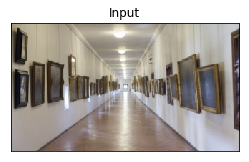

In [69]:
import scipy
from scipy.misc import imresize, imread, imshow
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = 'none'
%matplotlib inline

fig = plt.figure()
fig.set_figheight(9)
fig.set_figwidth(9)
import cv2
test = cv2.imread("./Test_Net_image/3.JPG")
print(test.shape)
test = imresize(test,(180,320,3))
#imshow(test)
test = test.transpose(2,0,1)
test = np.reshape(test,(1,3,180,320))
testx = batch_rgb_to_bgr(test)
test = test.astype(np.float32)
test1 = torch.from_numpy(test).float()
test1 = torch.div(test1,255.0)
mean1 = [0.485,0.456,0.406]
std1 = [0.229,0.224,0.225]
norm = Normalize(mean1,std1)
test1 = norm(test1)
test_pred = net.forward(Variable(test1, volatile=True).cuda())
print(test_pred[:,0]*(180/np.pi))
testx = np.reshape(testx,(3,180,320))
testx = testx.transpose(1,2,0)
testx = imresize(testx,(180,320,3))
#imshow(testx)
scipy.misc.imsave('test.png', testx)
a=fig.add_subplot(1,2,1)
imgplot = plt.imshow(testx)
a.set_title('Input')
a.axes.get_xaxis().set_visible(False)
a.axes.get_yaxis().set_visible(False)